# Machine Learning 2020 Course — Homework
## Protein Expression in Mice with Down Syndrome
### Made by: Francesco Gazzo [Matricola: 943652, ID: 10525731]
Average running time: 2' & 20''

# 0) Loading of dataset and initializations

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

In [2]:
# Read the training dataset and the test dataset
mice_train = pd.read_csv("train.csv")
mice_test = pd.read_csv("test.csv")

In [3]:
# Check if there are any samples with missing values
if ((np.any(mice_train.isna(), axis=1).sum()) != 0):
    print("There's some missing values for training dataset")
else:
    print("Everything is ok for training dataset")
    
if ((np.any(mice_test.isna(), axis=1).sum()) != 0):
    print("There's some missing values for test dataset")
else:
    print("Everything is ok for test dataset")

Everything is ok for training dataset
Everything is ok for test dataset


In [4]:
# Change the 'class' feature into categorical values from 0 to 7
def class_sorting(x):
    if(x['class'] == 'c-CS-s'):
        return 0
    elif(x['class'] == 'c-CS-m'):
        return 1
    elif(x['class'] == 'c-SC-s'):
        return 2
    elif(x['class'] == 'c-SC-m'):
        return 3
    elif(x['class'] == 't-CS-s'):
        return 4
    elif(x['class'] == 't-CS-m'):
        return 5
    elif(x['class'] == 't-SC-s'):
        return 6
    elif(x['class'] == 't-SC-m'):
        return 7
    
mice_train['class'] = mice_train.apply(class_sorting, axis=1)
mice_test['class'] = mice_test.apply(class_sorting, axis=1)

In [5]:
# Creation of two divided series with classes for both train and test
classes_train = mice_train.pop('class')
classes_test = mice_test.pop('class')

# 1.a) Preliminary Analysis

## Construction of the clustermap

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


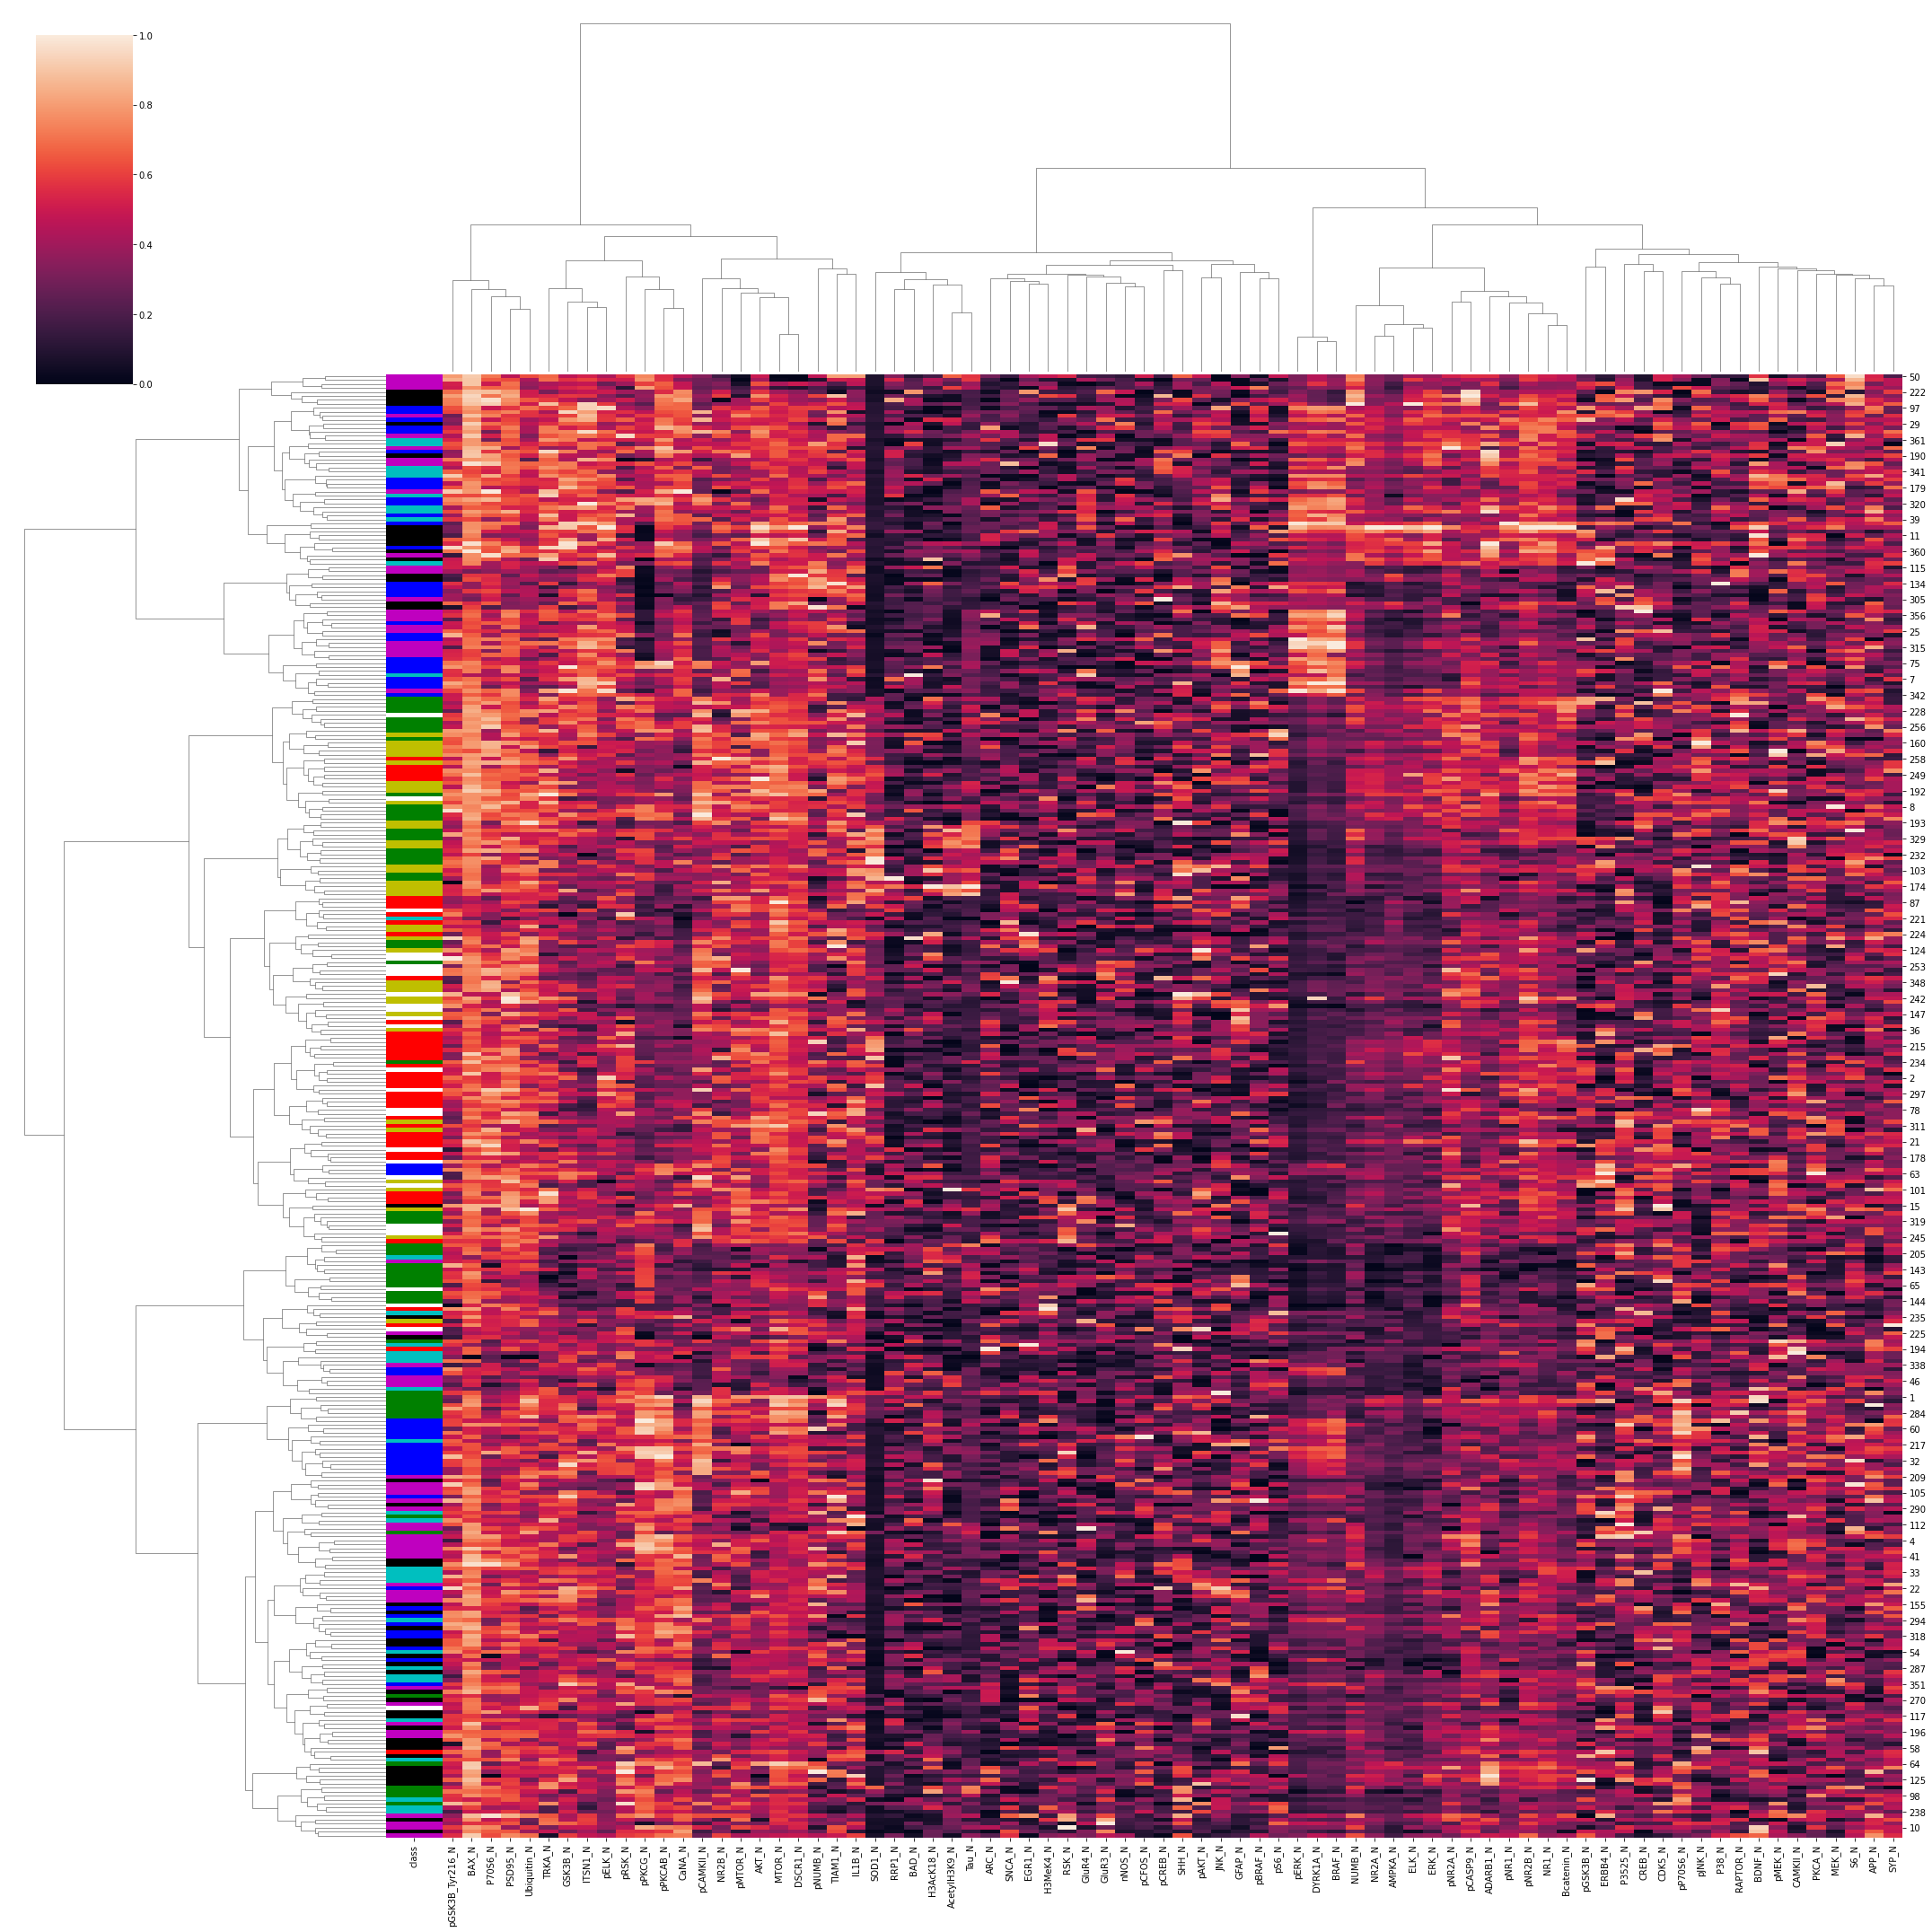

In [7]:
lut = dict(zip(classes_train.unique(), "bgrcmykw"))
row_colors = classes_train.map(lut)

sns.clustermap(mice_train, standard_scale=1, figsize = (30, 30), method='ward', row_colors=row_colors)

### Visual analysis
Knowing that:
- class 's-CS-s' is black
- class 'c-CS-m' is cyano
- class 'c-SC-s' is red
- class 'c-SC-m' is white
- class 't-CS-s' is magenta
- class 't-CS-m' is blue
- class 't-SC-s' is green
- class 't-SC-m' is yellow


From a visual perspective, it is possible to say that genes such as SOD1_N and pCAMKII_N seem to be significantly expressed by mice that have not been stimulated.
On the contrary, the pERK_N gene seems to be more expressed by mice that have been stimulated.

Anyway, in order to make stronger statements, we will have to compute classification.

# 1.b) Clustering

## Creation of function for plotting PCA
Using a PCA with only 3 variables we will be able to see how the points are ordered in the space.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import random
np.random.seed(0)

In [9]:
# Define PCA with 3 components, this will transform 
pca = PCA(n_components=3)
X_prj = pca.fit_transform(mice_train)

def plot3d(X, labels):
    # Set matplotlib as interactive
    # &matplotlib inline
    # Set matplotlib to generate static images
    # %matplotlib notebook
    # This import is required to set up the 3D environment
    from mpl_toolkits.mplot3d import Axes3D
    
    pca = PCA(n_components=3)
    # We consire images as simple vectors of 64 features
    #X = X.reshape(-1, 8*8)
    # Reduce features dimensionality, just for visualization
    # purpuses
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    # Convert negative values (outliers) into positive
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
          ('tab20' if nlabels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    # Plot the 3d coordinates (similar to standard scatter plots, we just
    # need to provide an additional z coordinate!)
    ax.scatter(xs=X_prj[:, 0], ys=X_prj[:, 1], zs=X_prj[:, 2], c=labels, cmap=cmap)
    # Plot a color bar on the right
    plt.colorbar(mappable=smap, label='classes', ticks=range(nlabels))

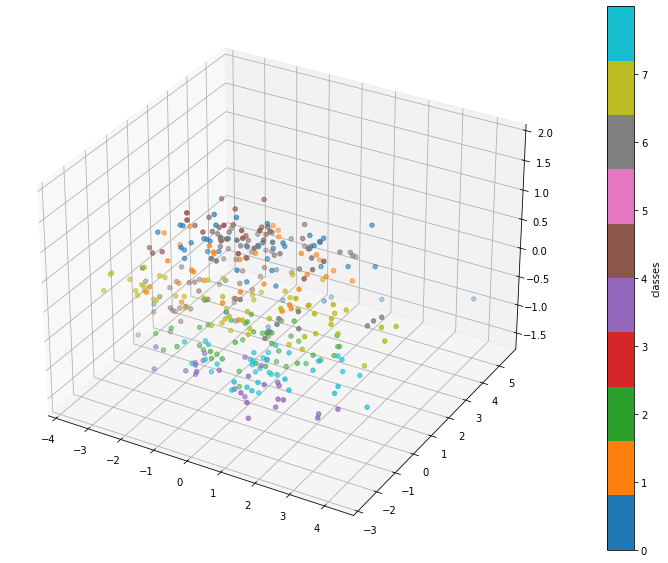

In [10]:
# Plot of the original classes
plot3d(mice_train ,labels=classes_train)

## Agglomerative algorithm
We will try to cluster the train dataset using a bottom-up approach.

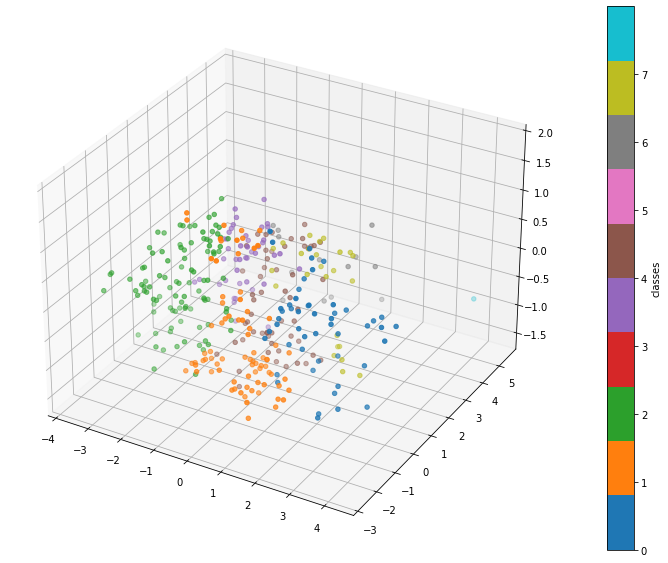

In [11]:
from sklearn.cluster import AgglomerativeClustering
distance_threshold=None#270
n_clusters=8

model_agglomerative = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity='euclidean', linkage='complete')

y_predict = model_agglomerative.fit_predict(mice_train)

plot3d(mice_train, labels=y_predict)

## K-means
We will try to cluster the train dataset with a K-mean approach, using three different initialization of the centroids: a random one, a ++ approach and a hierarchical one.

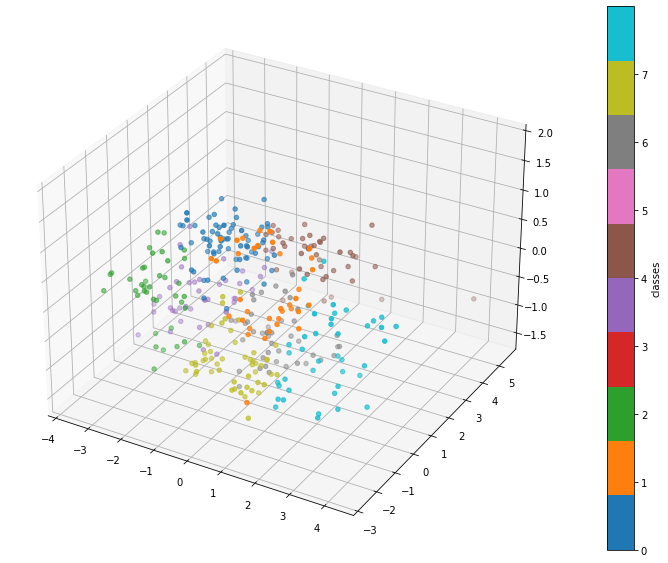

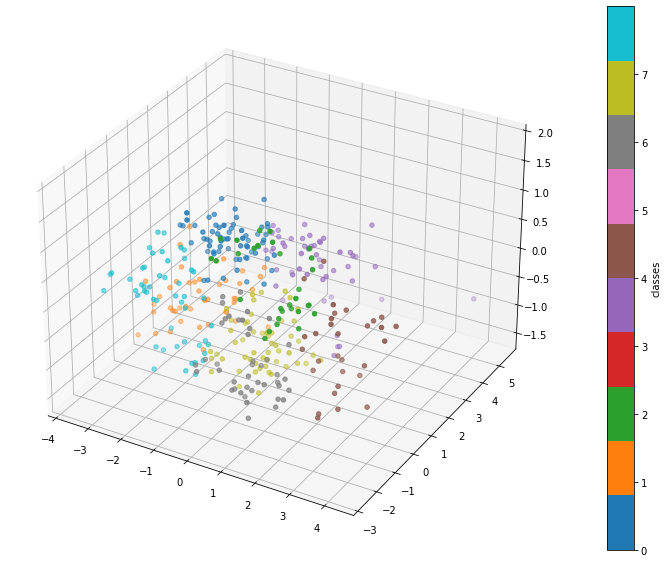

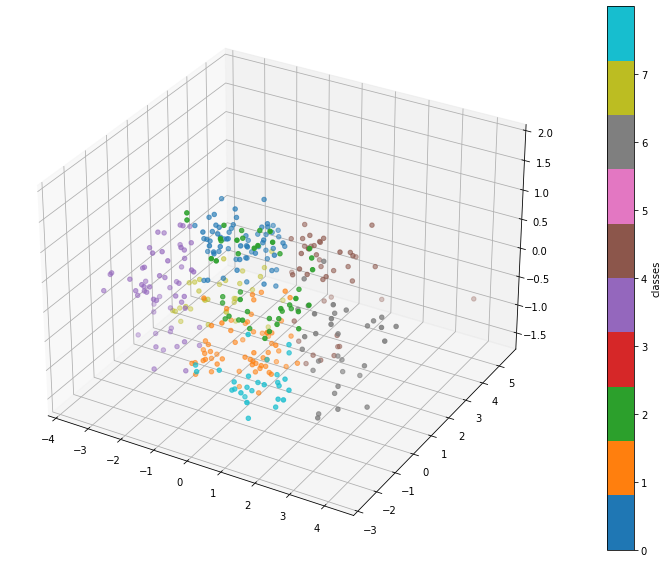

In [12]:
from sklearn.cluster import KMeans

# Random
model_random = KMeans(n_clusters=8, init='random', random_state=0)
y_predict = model_random.fit_predict(mice_train)
plot3d(mice_train, labels=y_predict)

# K-Means++
model_plus = KMeans(n_clusters=8, init='k-means++', random_state=0)
y_predict = model_plus.fit_predict(mice_train)
plot3d(mice_train, labels=y_predict)

# Hierarchical
hmodel = AgglomerativeClustering(n_clusters=8, 
                                distance_threshold=distance_threshold, 
                                affinity='euclidean', linkage='ward')
y_predict = hmodel.fit_predict(mice_train)
centroids = np.stack([mice_train[y_predict == k].mean(0) for k in range(8)])
model_hierc = KMeans(n_clusters=8, init=centroids, n_init=1, random_state=0)
y_predict = model_hierc.fit_predict(mice_train)
plot3d(mice_train, labels=y_predict)

### Visual analysis of clustering
Thanks to the PCA technique, we are able to see how the samples are assigned with the various clustering methods.

Even without a statistical parameter, we are able to say that all the 3 clustering methods do not produce good results, being not able to split the dataset in the 8 original classes.

## Statistical evaluation: Precision, Recall and Purity

In [13]:
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

In [14]:
# Total purity of the 4 models
print("Agglomerative algorithm purity", tot_purity(model_agglomerative.fit_predict(mice_train), classes_train))
print("Random Kmeans purity", tot_purity(model_random.fit_predict(mice_train), classes_train))
print("Kmeans++ purity", tot_purity(model_plus.fit_predict(mice_train), classes_train))
print("Hierarchical+Kmeans purity", tot_purity(model_hierc.fit_predict(mice_train), classes_train))

Agglomerative algorithm purity 0.3351498636618552
Random Kmeans purity 0.43596730235531556
Kmeans++ purity 0.43324250671578396
Hierarchical+Kmeans purity 0.389645776477596


### Purity analysis
Considering the purity, that is a measure of the extent to which clusters contain a single class, and considering that all these parameters are even below 0.5, we can say that we were not able to perform a good clustering, not being able to reconstruct the original 8 classes.

The possible motivations to such a bad result are:
- dataset available not sufficiently big
- shapes of the classes not globular
- original classes not well-separated

# 2) Classification

In [15]:
# Remove 'SOD1_N' because not present in test dataset
new_train = mice_train.drop('SOD1_N', axis=1)

## Forward Feature Selection
Entire dataset possibly has lot of features not significant or some features that are correlated between each others and need to be removed.

We will perform Forward Feature Selection fitting a SVC model, but before doing it we will compute a grid search looking for the best C parameter.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 70, 100, 1000]}]

scores = ['precision', 'recall']
cv = 5

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(new_train, classes_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = classes_test, clf.predict(mice_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 70, 100, 1000], 'kernel': ['linear']}],
             scoring='precision_macro')

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.057 (+/-0.086) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.057 (+/-0.086) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.373 (+/-0.121) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.057 (+/-0.086) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.705 (+/-0.108) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.372 (+/-0.121) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.745 (+/-0.044) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.678 (+/-0.091) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.730 (+/-0.023) for {'C': 1, 'kernel': 'linear'}
0.719 (+/-0.051) for {'C': 10, 'kernel': 'linear'}
0.719 (+/-0.051) for {'C': 70, 'kernel': 'linear'}
0.719 (+/-0.051) for {'C': 100, 'kernel': 'linear'}
0.719 (+/-0.051) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores ar

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 70, 100, 1000], 'kernel': ['linear']}],
             scoring='recall_macro')

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.161 (+/-0.065) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.161 (+/-0.065) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.381 (+/-0.053) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.161 (+/-0.065) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.703 (+/-0.070) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.381 (+/-0.053) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.733 (+/-0.058) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.697 (+/-0.075) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.721 (+/-0.034) for {'C': 1, 'kernel': 'linear'}
0.710 (+/-0.053) for {'C': 10, 'kernel': 'linear'}
0.710 (+/-0.053) for {'C': 70, 'kernel': 'linear'}
0.710 (+/-0.053) for {'C': 100, 'kernel': 'linear'}
0.710 (+/-0.053) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores ar

The best choice is a Linear boundary with C equal to 10

............
Best model (M1) with 1 features: ['DYRK1A_N']
M1 subset score (3.): 0.34849849849849857
............
Best model (M2) with 2 features: ['DYRK1A_N', 'pPKCG_N']
M2 subset score (3.): 0.5093843843843844
............
Best model (M3) with 3 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N']
M3 subset score (3.): 0.6372372372372371
............
Best model (M4) with 4 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N']
M4 subset score (3.): 0.6920420420420421
............
Best model (M5) with 5 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N']
M5 subset score (3.): 0.7027027027027029
............
Best model (M6) with 6 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N']
M6 subset score (3.): 0.7355855855855856
............
Best model (M7) with 7 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N']
M7 subset score (3.): 0.7574324324324324
............
Best model (M8) with 8 features: ['DYRK1A_N', 'pPKCG_

............
Best model (M33) with 33 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N', 'CREB_N']
M33 subset score (3.): 0.7247747747747748
............
Best model (M34) with 34 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N', 'CREB_N', 'GluR4_N']
M34 subset score (3.): 0.7437687687687687
............
Best model (M35) with 35 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKC

............
Best model (M49) with 49 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N', 'CREB_N', 'GluR4_N', 'pAKT_N', 'TRKA_N', 'pNR2B_N', 'ERK_N', 'AKT_N', 'EGR1_N', 'RSK_N', 'APP_N', 'NR1_N', 'GSK3B_N', 'CAMKII_N', 'pP70S6_N', 'S6_N', 'Bcatenin_N', 'GluR3_N']
M49 subset score (3.): 0.7572072072072074
............
Best model (M50) with 50 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N

............
Best model (M62) with 62 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N', 'CREB_N', 'GluR4_N', 'pAKT_N', 'TRKA_N', 'pNR2B_N', 'ERK_N', 'AKT_N', 'EGR1_N', 'RSK_N', 'APP_N', 'NR1_N', 'GSK3B_N', 'CAMKII_N', 'pP70S6_N', 'S6_N', 'Bcatenin_N', 'GluR3_N', 'H3MeK4_N', 'ITSN1_N', 'MEK_N', 'P70S6_N', 'GFAP_N', 'ELK_N', 'P3525_N', 'pNUMB_N', 'SHH_N', 'IL1B_N', 'PSD95_N', 'JNK_N', 'NR2B_N']
M62 subset score (3.): 0.7081081081081081
............
Best model (M63) with 63 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 

............
Best model (M73) with 73 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N', 'P38_N', 'pCFOS_N', 'BAD_N', 'pCASP9_N', 'BDNF_N', 'pBRAF_N', 'MTOR_N', 'ADARB1_N', 'AcetylH3K9_N', 'pMEK_N', 'H3AcK18_N', 'RAPTOR_N', 'PKCA_N', 'BAX_N', 'ARC_N', 'DSCR1_N', 'RRP1_N', 'pERK_N', 'pRSK_N', 'BRAF_N', 'ERBB4_N', 'TIAM1_N', 'CREB_N', 'GluR4_N', 'pAKT_N', 'TRKA_N', 'pNR2B_N', 'ERK_N', 'AKT_N', 'EGR1_N', 'RSK_N', 'APP_N', 'NR1_N', 'GSK3B_N', 'CAMKII_N', 'pP70S6_N', 'S6_N', 'Bcatenin_N', 'GluR3_N', 'H3MeK4_N', 'ITSN1_N', 'MEK_N', 'P70S6_N', 'GFAP_N', 'ELK_N', 'P3525_N', 'pNUMB_N', 'SHH_N', 'IL1B_N', 'PSD95_N', 'JNK_N', 'NR2B_N', 'SNCA_N', 'SYP_N', 'Ubiquitin_N', 'nNOS_N', 'pCREB_N', 'pELK_N', 'pGSK3B_N', 'pGSK3B_Tyr216_N', 'pJNK_N', 'pMTOR_N', 'pNR1_N']
M73 subset score (3.): 0.7331081081081081
............
Best model (M74) with 74 features: ['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 'NR2A_N', 'CDK5_N', 'CaN

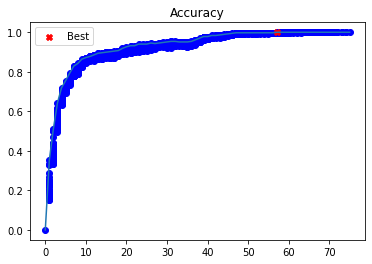

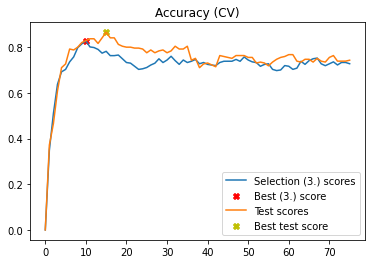

In [17]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(len(all_features)):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = SVC(kernel='linear', C=10)
            model = model.fit(Xtrain_sub, ytrain)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how the 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.shape[0]

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
cv = 10
forward_selection(new_train, classes_train, mice_test, classes_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

## Comparison of different classification algorithms
### Logistic vs LDA vs QDA vs SVP: comparison with accuracy

Thanks to the forward feature selection we have been able to select 10 features

In [18]:
new_train = new_train[['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 
                       'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N']]
new_test = mice_test[['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 
                       'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N']]

We will now fit four different models using the 10 selected features.

In [19]:
# Fit the regression model
model_regr = LogisticRegression(solver="newton-cg", penalty='none', multi_class='auto', max_iter=1000)
model_regr = model_regr.fit(new_train, classes_train)
print("Logistic Train accuracy:", accuracy(classes_train, model_regr.predict(new_train)))
print("Logistic Test accuracy:", accuracy(classes_test, model_regr.predict(new_test)))
print("")

# Fit the LDA model
model_lda = LDA(store_covariance=True)
model_lda = model_lda.fit(new_train, classes_train)
print("LDA Train accuracy:", accuracy(classes_train, model_lda.predict(new_train)))
print("LDA Test accuracy:", accuracy(classes_test, model_lda.predict(new_test)))
print("")

# Fit the QDA model
model_qda = QDA(store_covariance=True)
model_qda = model_qda.fit(new_train, classes_train)
print("QDA Train accuracy:", accuracy(classes_train, model_qda.predict(new_train)))
print("QDA Test accuracy:", accuracy(classes_test, model_qda.predict(new_test)))
print("")

# Fit the SVC model
model_svc = SVC(kernel='linear', C=10)
mode_svc = model_svc.fit(new_train, classes_train)
print("SVC Train accuracy:", accuracy(classes_train, model_svc.predict(new_train)))
print("SVC Test accuracy:", accuracy(classes_test, model_svc.predict(new_test)))

Logistic Train accuracy: 0.9591280653950953
Logistic Test accuracy: 0.8489795918367347

LDA Train accuracy: 0.8256130790190735
LDA Test accuracy: 0.8489795918367347

QDA Train accuracy: 0.9863760217983651
QDA Test accuracy: 0.9591836734693877

SVC Train accuracy: 0.8719346049046321
SVC Test accuracy: 0.8285714285714286


### Evaluation
By simply looking at the accuracy, that represents the fraction of predictions our model got right, we can say that the QDA model performs the best, while Regression and SVC perform better than LDA.

Let's now give a look at other statistics taking into account only the three better models.

### Logistic vs QDA vs SVC: comparison with report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(classes_test, model_regr.predict(new_test), 
                            target_names=['c-CS-s','c-CS-m','c-SC-s','c-SC-m',
                                          't-CS-s','t-CS-m','t-SC-s','t-SC-m']))

print(classification_report(classes_test, model_qda.predict(new_test), 
                            target_names=['c-CS-s','c-CS-m','c-SC-s','c-SC-m',
                                          't-CS-s','t-CS-m','t-SC-s','t-SC-m']))

print(classification_report(classes_test, model_svc.predict(new_test), 
                            target_names=['c-CS-s','c-CS-m','c-SC-s','c-SC-m',
                                          't-CS-s','t-CS-m','t-SC-s','t-SC-m']))

              precision    recall  f1-score   support

      c-CS-s       0.89      0.89      0.89        27
      c-CS-m       0.76      0.54      0.63        24
      c-SC-s       0.88      0.97      0.92        30
      c-SC-m       0.91      0.94      0.92        32
      t-CS-s       0.80      0.97      0.88        33
      t-CS-m       0.73      0.67      0.70        33
      t-SC-s       0.91      0.95      0.93        44
      t-SC-m       0.84      0.73      0.78        22

    accuracy                           0.85       245
   macro avg       0.84      0.83      0.83       245
weighted avg       0.85      0.85      0.84       245

              precision    recall  f1-score   support

      c-CS-s       1.00      0.93      0.96        27
      c-CS-m       0.88      0.92      0.90        24
      c-SC-s       0.97      1.00      0.98        30
      c-SC-m       0.97      0.94      0.95        32
      t-CS-s       0.92      1.00      0.96        33
      t-CS-m       0.97 

### Evaluation
Also in this case we are able to say that QDA performs the best, it has the higher precision, recall and f1-score for all the different classes.

In conclusion, because the QDA is the the best solution, we can say that the data follow a Gaussian distribution with different covariance matrices.

# 3) Regression


We now want to recover from the loss of SOD1_N features on test samples.

We will do it by training a regressor.

Because we have no test data, we will split the training one into two, in order to be able to compute a check.

In [21]:
sod1_train = mice_train['SOD1_N']
new_train = mice_train.drop('SOD1_N',axis=1)

from sklearn.model_selection import train_test_split

mice_test_size = 0.1
mice_test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(new_train, sod1_train,
                                                    test_size=mice_test_size, 
                                                    random_state=mice_test_seed)

## Linear Regression
As for the classification, we will perform a Forward Feature Selection, fitting a cross-validated linear regressor, in order to choose the best features able to predict SOD1_N.

In [22]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(len(all_features)):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    
def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

............
Best model (M0) with 0 features: ['pERK_N']
M0 subset score (3.): 0.3741893837974686
............
Best model (M1) with 1 features: ['pERK_N', 'Bcatenin_N']
M1 subset score (3.): 0.4979617330415459
............
Best model (M2) with 2 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N']
M2 subset score (3.): 0.6816628473163677
............
Best model (M3) with 3 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N']
M3 subset score (3.): 0.7134301960073384
............
Best model (M4) with 4 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N']
M4 subset score (3.): 0.7555321807856431
............
Best model (M5) with 5 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N']
M5 subset score (3.): 0.7601922001559371
............
Best model (M6) with 6 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N']
M6 subset score (3.): 0.7544932055800477
............
Best model (M7) with 7 features: ['pERK_N', 'Bcatenin_N'

............
Best model (M33) with 33 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N', 'pNR2B_N', 'nNOS_N', 'P38_N', 'CAMKII_N', 'pNR1_N', 'CaNA_N', 'pRSK_N', 'pNUMB_N', 'GluR3_N', 'RAPTOR_N']
M33 subset score (3.): 0.6606605430568242
............
Best model (M34) with 34 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N', 'pNR2B_N', 'nNOS_N', 'P38_N', 'CAMKII_N', 'pNR1_N', 'CaNA_N', 'pRSK_N', 'pNUMB_N', 'GluR3_N', 'RAPTOR_N', 'pS6_N']
M34 subset score (3.): 0.6543722588923704
............
Best model (M35) with 35 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N

............
Best model (M50) with 50 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N', 'pNR2B_N', 'nNOS_N', 'P38_N', 'CAMKII_N', 'pNR1_N', 'CaNA_N', 'pRSK_N', 'pNUMB_N', 'GluR3_N', 'RAPTOR_N', 'pS6_N', 'ITSN1_N', 'BAX_N', 'GluR4_N', 'RSK_N', 'pJNK_N', 'APP_N', 'JNK_N', 'IL1B_N', 'MEK_N', 'NR1_N', 'pGSK3B_N', 'NR2A_N', 'pBRAF_N', 'BAD_N', 'BDNF_N', 'SHH_N']
M50 subset score (3.): 0.6597330074868551
............
Best model (M51) with 51 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N', 'pNR2B_N', 'nNOS_N', 'P38_N', 'CAMKII_N', 'pNR1_N', 'CaNA_N', 'pRSK_N', 'pNUMB_N',

............
Best model (M65) with 65 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N', 'pNR2B_N', 'nNOS_N', 'P38_N', 'CAMKII_N', 'pNR1_N', 'CaNA_N', 'pRSK_N', 'pNUMB_N', 'GluR3_N', 'RAPTOR_N', 'pS6_N', 'ITSN1_N', 'BAX_N', 'GluR4_N', 'RSK_N', 'pJNK_N', 'APP_N', 'JNK_N', 'IL1B_N', 'MEK_N', 'NR1_N', 'pGSK3B_N', 'NR2A_N', 'pBRAF_N', 'BAD_N', 'BDNF_N', 'SHH_N', 'AcetylH3K9_N', 'PSD95_N', 'pAKT_N', 'pMTOR_N', 'TIAM1_N', 'SYP_N', 'pCASP9_N', 'CDK5_N', 'TRKA_N', 'GSK3B_N', 'RRP1_N', 'P70S6_N', 'Ubiquitin_N', 'S6_N', 'GFAP_N']
M65 subset score (3.): 0.6676338148672301
............
Best model (M66) with 66 features: ['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 'SNCA_N',

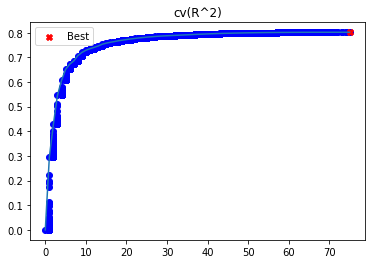

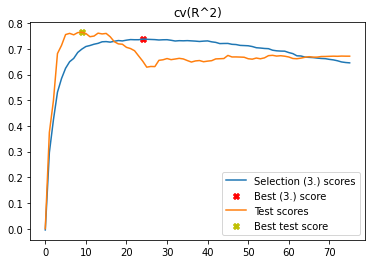

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sigma = estimate_sigma(X_train, y_train)
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(r2_score), cv=5), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

We have selected 28 features, let's now fit a Linear Regression and look to the R2 score.

In [24]:
X_train = X_train[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 
                   'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 
                   'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N']]

X_test = X_test[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'pPKCG_N', 
                   'AMPKA_N', 'AKT_N', 'pELK_N', 'ARC_N', 'DSCR1_N', 'pNR2A_N', 'BRAF_N', 'DYRK1A_N', 
                   'SNCA_N', 'CREB_N', 'pCREB_N', 'EGR1_N', 'ELK_N', 'ERK_N', 'ERBB4_N', 'pP70S6_N', 'NUMB_N']]

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Fit the LinearRegression predictor
model = LinearRegression(fit_intercept=True) # 1- hyperparams selection
model = model.fit(X_train, y_train)          # 2- model fitting
y_predict = model.predict(X_test)            # 3- prediction
y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.7802527070451578
Train MSE score  0.01846318830438848
Test R2 score  0.652215663803213
Test MSE score  0.02766678677322296


### Evaluation
The R2 scores for Train and Test dataset are not perfect (=1), but still bigger than 0.5.

Possibly a different regressor could perform better, let's try with a polynomial regression.

## Polynomial Regression

### Hyperparameters selection

We will perform a Grid Search cross-validated testing for different degrees of polynomial regression.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=list(range(1,5)), include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5)
cv.fit(X_train, y_train)

model = cv.best_estimator_
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=[1, 2, 3, 4],
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

Best degree: 1
Train score: 0.7377729093438826
Test score: 0.6522156638032137


### Evaluation

The result of the strong cross-validated Grid Search tells us that the best Polynomial Regressor is the one with a degree of 1, basically the Linear one that we tested at the beginning of the regression.

## LassoCV
We will try to fit a Linear Model after having performed a feature selection with Lasso and having selected the best model with cross-validation.

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
X, y = make_regression(noise=3, random_state=0)
reg = LassoCV(cv=5, random_state=0).fit(mice_train, classes_train)
reg.score(mice_train, classes_train)

0.6676828617059436

### Evaluation
Again the better model is the first Linear one.

# 4) Recover, predict and test

Thanks to the Linear Regressor we trained in the previous step, we will be able to predict the SOD1_N expression also for the test dataset.

In [28]:
mice_regression = mice_train[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'AMPKA_N', 
                   'pPKCG_N', 'ADARB1_N', 'AKT_N', 'ARC_N', 'pELK_N', 'DSCR1_N', 'pNR2A_N', 
                   'BRAF_N', 'SNCA_N', 'pCREB_N', 'DYRK1A_N', 'CREB_N', 'pNUMB_N', 'ELK_N', 
                   'pP70S6_N', 'EGR1_N', 'ERBB4_N', 'ERK_N', 'NUMB_N', 'SHH_N', 'pNR1_N', 'GSK3B_N']]
mice_prediction = mice_test[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'AMPKA_N', 
                   'pPKCG_N', 'ADARB1_N', 'AKT_N', 'ARC_N', 'pELK_N', 'DSCR1_N', 'pNR2A_N', 
                   'BRAF_N', 'SNCA_N', 'pCREB_N', 'DYRK1A_N', 'CREB_N', 'pNUMB_N', 'ELK_N', 
                   'pP70S6_N', 'EGR1_N', 'ERBB4_N', 'ERK_N', 'NUMB_N', 'SHH_N', 'pNR1_N', 'GSK3B_N']]

model = LinearRegression(fit_intercept=True)
model = model.fit(mice_regression, sod1_train)
sod1_predicted = model.predict(mice_prediction)
sod1_predicted = pd.Series(sod1_predicted)

In [29]:
# Set the same dataset used for classification adding the 'SOD1_N' class
final_train = mice_train[['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 
                       'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N']].copy()
final_test = mice_test[['DYRK1A_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'pPKCAB_N', 
                       'NR2A_N', 'CDK5_N', 'CaNA_N', 'NUMB_N', 'AMPKA_N']].copy()
final_train['SOD1_N'] = sod1_train
final_test['SOD1_N'] = sod1_predicted

## Logistic vs QDA vs SVC
We will now compute again the logistic, QDA and SVC classification methods, in order to see if the add of 'SOD1_N' has increased the accuracy.

In [30]:
# Fit the regression model
model_regr = LogisticRegression(solver="newton-cg", penalty='none', multi_class='auto', max_iter=1000)
model_regr = model_regr.fit(final_train, classes_train)
print("Logistic Train accuracy:", accuracy(classes_train, model_regr.predict(final_train)))
print("Logistic Test accuracy:", accuracy(classes_test, model_regr.predict(final_test)))
print("")

# Fit the QDA model
model_qda = QDA(store_covariance=True)
model_qda = model_qda.fit(final_train, classes_train)
print("QDA Train accuracy:", accuracy(classes_train, model_qda.predict(final_train)))
print("QDA Test accuracy:", accuracy(classes_test, model_qda.predict(final_test)))
print("")

# Fit the SVC model
model_svc = SVC(kernel='linear', C=10)
mode_svc = model_svc.fit(final_train, classes_train)
print("SVC Train accuracy:", accuracy(classes_train, model_svc.predict(final_train)))
print("SVC Test accuracy:", accuracy(classes_test, model_svc.predict(final_test)))

Logistic Train accuracy: 0.9509536784741145
Logistic Test accuracy: 0.7387755102040816

QDA Train accuracy: 0.9918256130790191
QDA Test accuracy: 0.7714285714285715

SVC Train accuracy: 0.8773841961852861
SVC Test accuracy: 0.8367346938775511


Previous accuracies:
- Logistic Train accuracy: 0.9591280653950953
- Logistic Test accuracy: 0.8489795918367347

- QDA Train accuracy: 0.9863760217983651
- QDA Test accuracy: 0.9591836734693877

- SVC Train accuracy: 0.8719346049046321
- SVC Test accuracy: 0.8285714285714286

# 5) Conclusion
The add of the 'SOD1_N' feature has increased the performance of the classification on the train dataset, in particular for the QDA model, that already was the best one.

Unfortunately, the accuracy for the test dataset has decreased (apart from the SVC model that has had a low increment).

This difference between the performance of train and test datasets tells us that our Linear Regressor has not been able to predict in the right way the gene expression of 'SOD1_N', causing a worsening in the accuracy of the classification. At the same time, we can say that 'SOD1_N' would have been probably the best feature to use for perfoming a good classification.

So, the best solution would be to perform again the analyses on the test mice and gain the data relative also to the 'SOD1_N' expression. If this would have not been possible, the best classifier would remain the QDA not considering the 'SOD1_N' predicted.